<center><h1>Sun_Kaiyi_HW6</h1></center>

### Number of Late Days used: 1

Name: Kaiyi Sun 
<br>
Github Username: KaiyiSss
<br>
USC ID: 6511379529

## 1. Tree-Based Methods

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### (a) Download the APS Failure data

In [2]:
train_set = pd.read_csv('../data/aps_failure_training_set.csv',skiprows=20, na_values='na')
test_set = pd.read_csv('../data/aps_failure_test_set.csv',skiprows=20,  na_values='na')

In [3]:
train_x, train_y = train_set.iloc[:,1:], train_set[['class']]
features = train_x.columns

In [4]:
test_x, test_y = test_set.iloc[:, 1:],test_set[['class']]

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

Reference: https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87

Common techniques inlcude: Mean, Mode, Median, KNN Imputation, Iterative Imputation

In [5]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

#### (ii) Calculate the coefficient of variation

In [6]:
full_data = np.concatenate([train_x,test_x],axis=0)
data_table = pd.DataFrame(full_data, columns=features)
data_table

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,81852.0,0.713189,2.130706e+09,892.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,18.0,0.000000,5.200000e+01,46.000000,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,79636.0,0.713189,1.670000e+03,1518.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,110.0,0.713189,3.600000e+01,32.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


In [7]:
stats = data_table.describe().T
mean_stats, std_stats = stats['mean'],stats['std']
cv_data = std_stats/mean_stats
cv_data

aa_000      4.328608
ab_000      2.207351
ac_000      2.167798
ad_000    193.955307
ae_000     22.282263
             ...    
ee_007      4.885304
ee_008      3.335353
ee_009      5.754213
ef_000     47.781107
eg_000     45.711130
Length: 170, dtype: float64

#### (iii) Plot a correlation matrix

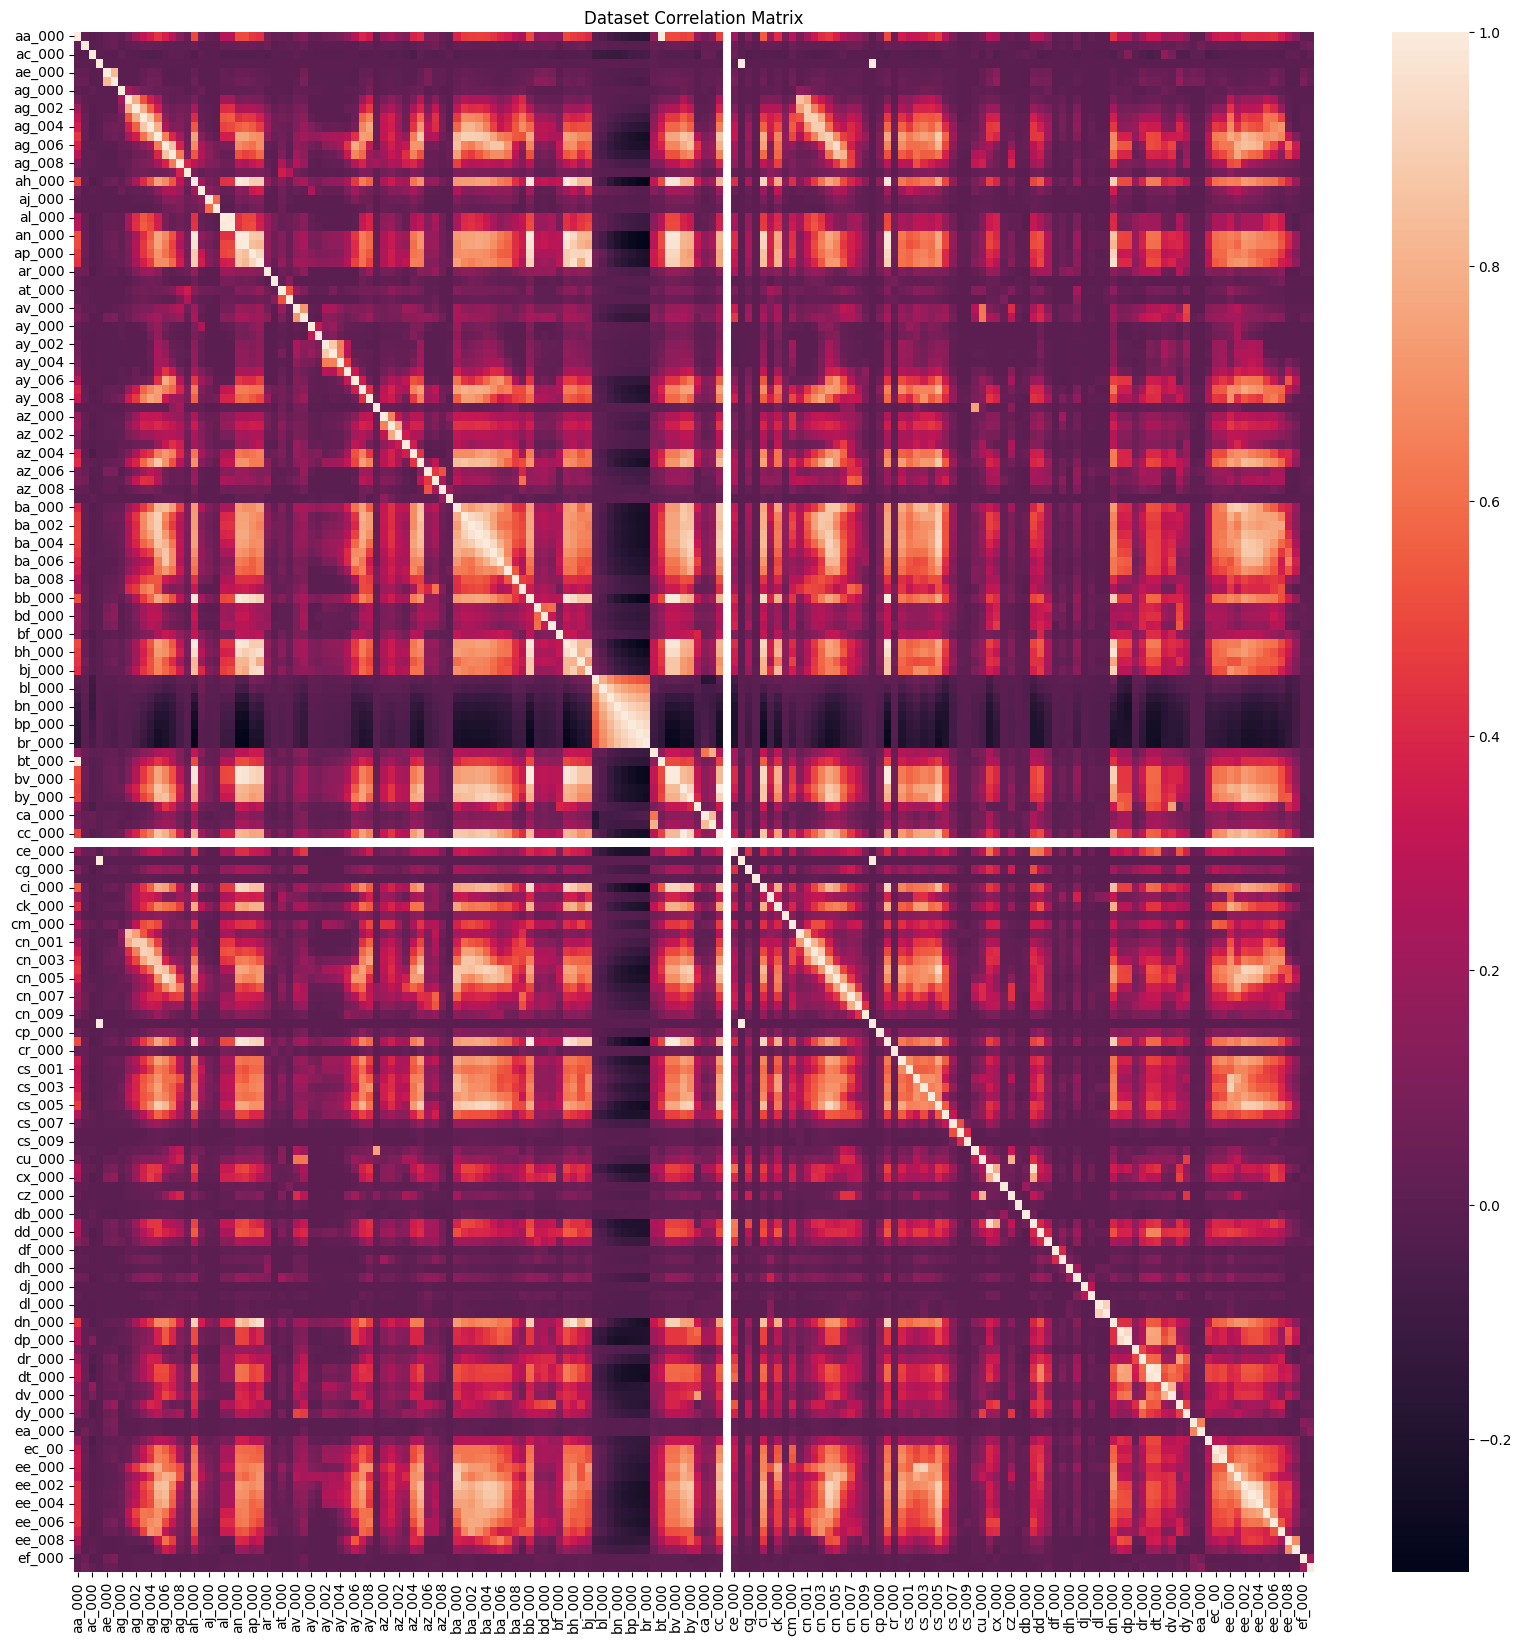

In [8]:
fig, axes = plt.subplots(figsize=(20, 20))
sns.heatmap(data_table.corr(), ax=axes)
plt.title("Dataset Correlation Matrix")
plt.show()

#### (iv) Make scatter plots and box plots

In [9]:
sorted_cv = cv_data.sort_values(ascending=False)
best_cvs = sorted_cv[:int(np.sqrt(170))]
best_cvs

cf_000    194.438323
co_000    194.089168
ad_000    193.955307
cs_009    193.045035
dj_000    120.084900
df_000    116.138172
as_000    114.464381
dh_000    111.946396
ag_000     91.351287
au_000     86.293581
ak_000     78.559993
az_009     77.894525
ay_009     77.457761
dtype: float64

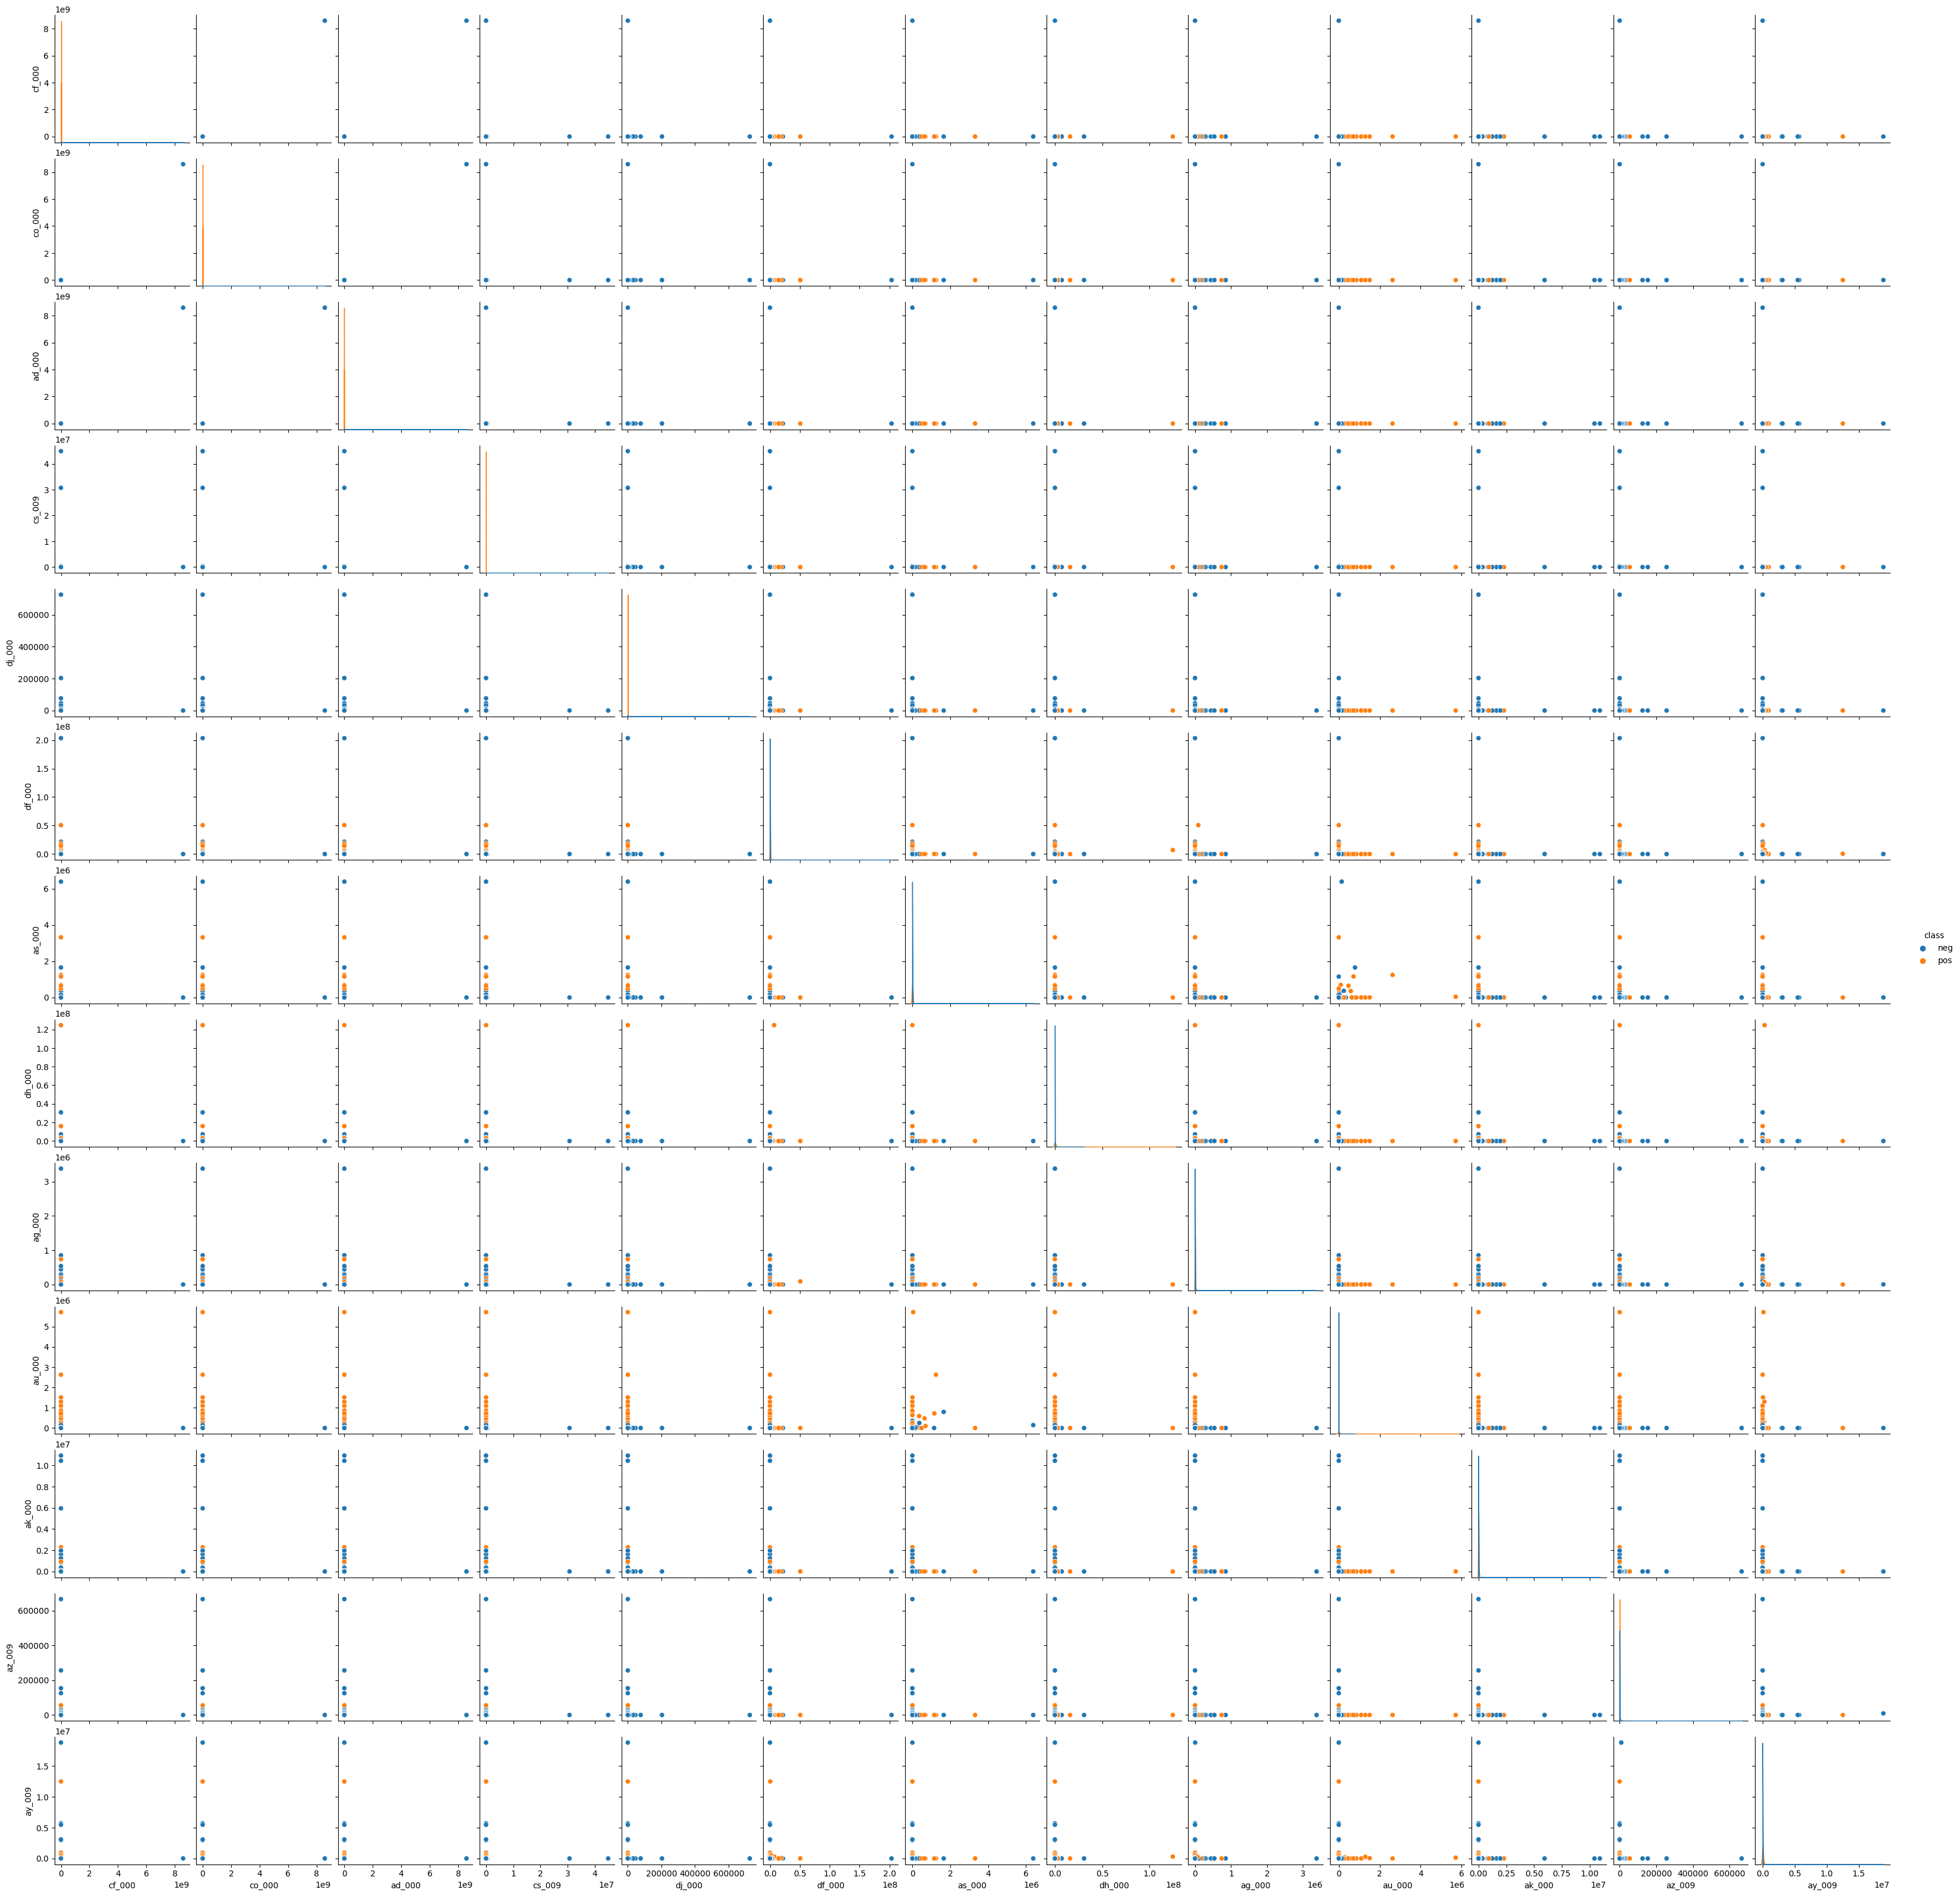

In [10]:
data_classes = pd.concat([train_y, test_y], ignore_index=True)
scatter_plot = pd.concat([data_table[best_cvs.index], data_classes],axis=1)
sns.pairplot(scatter_plot, hue='class')

[None]

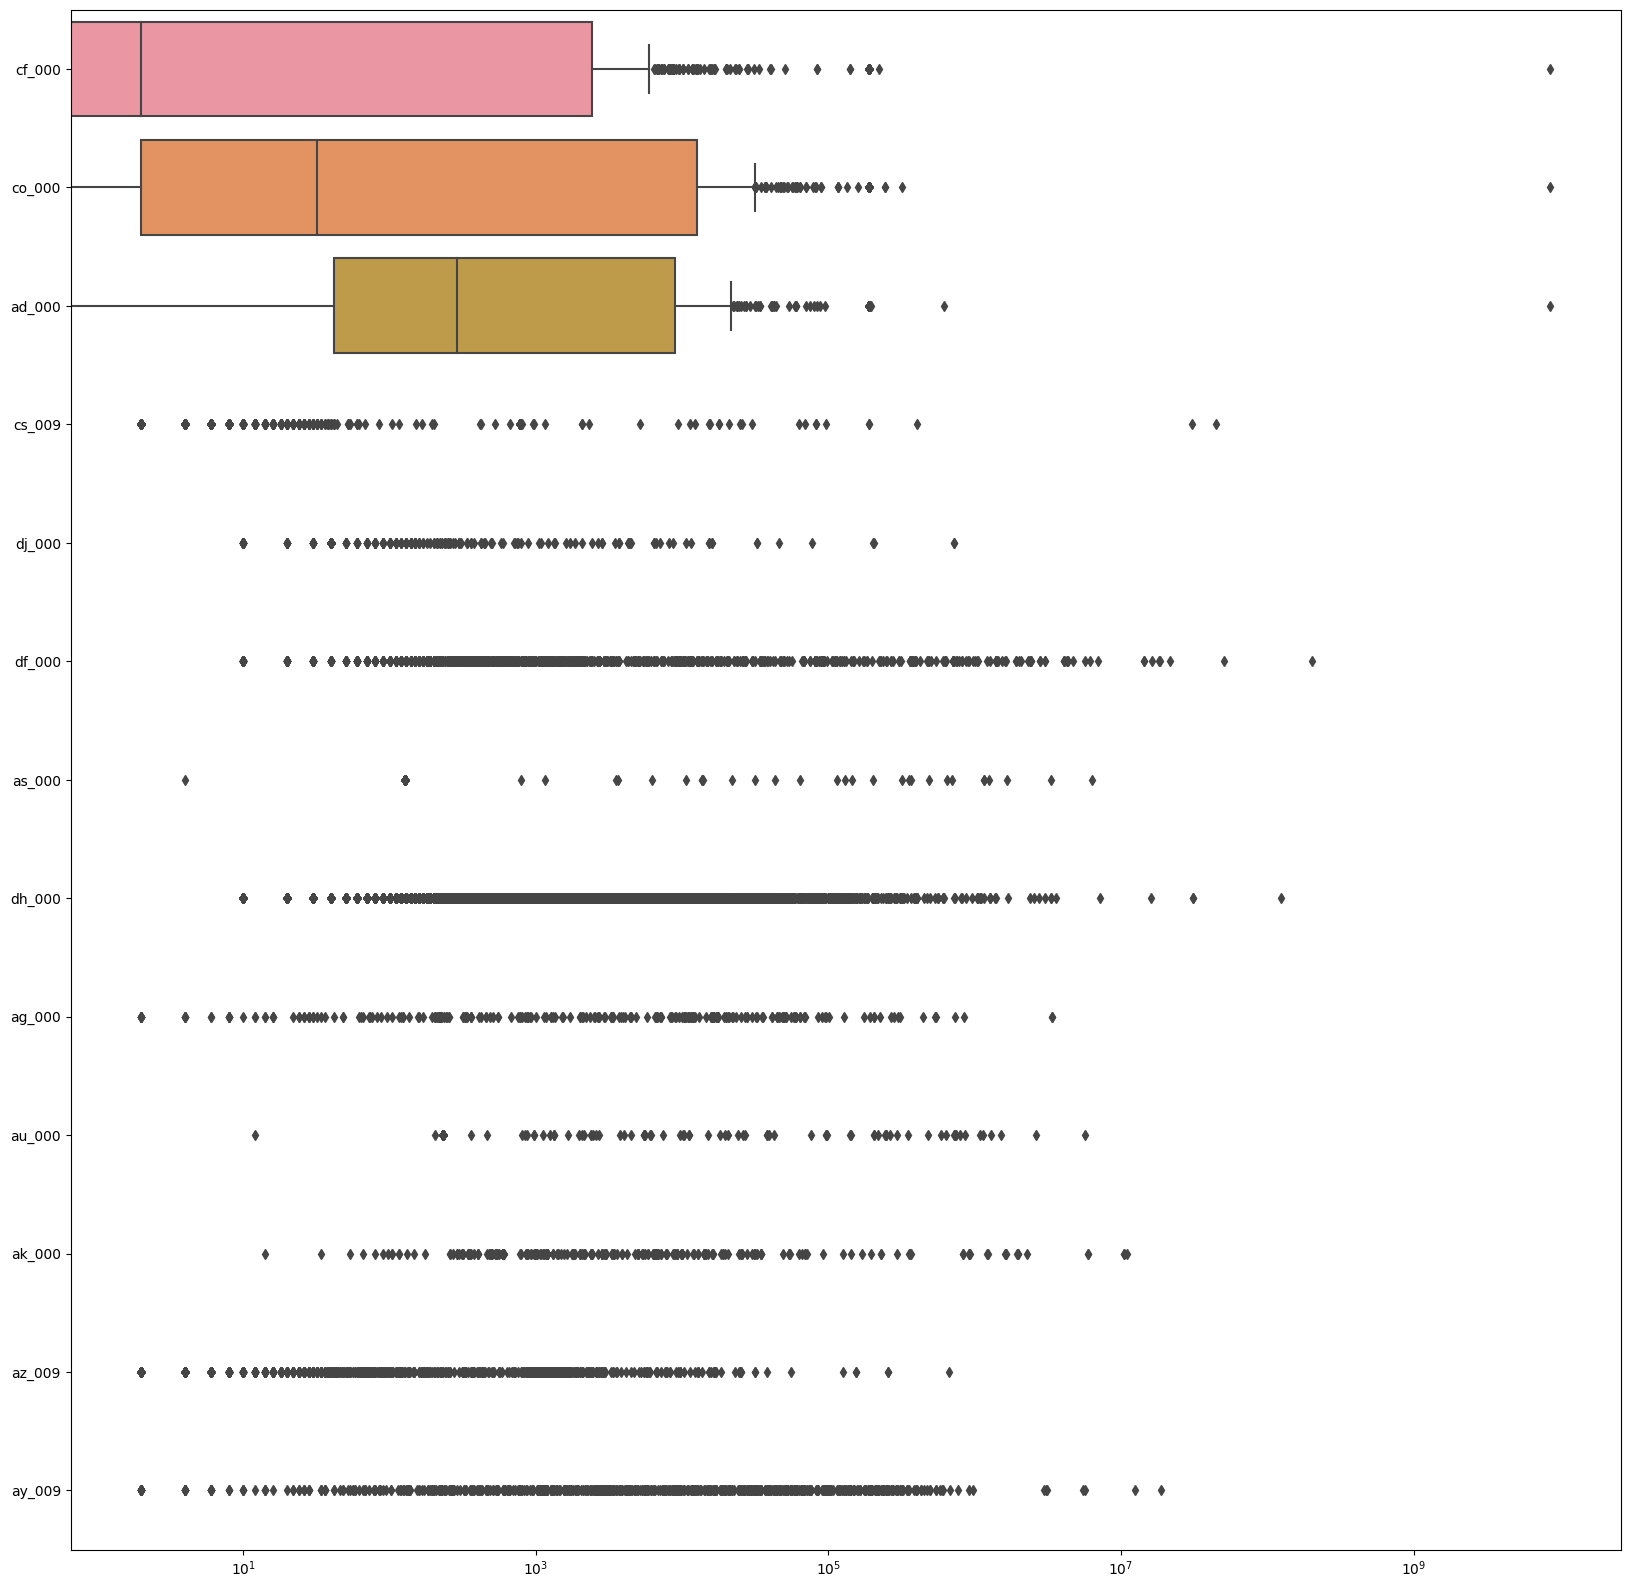

In [42]:
# https://stackoverflow.com/questions/55777491/how-to-plot-large-range-values-with-matplotlib
# https://seaborn.pydata.org/generated/seaborn.objects.Plot.scale.html

fig, axes = plt.subplots(figsize=(20, 20))
sns.boxplot(data_table[best_cvs.index], orient='h').set(xscale='log')

#### It was difficult to visualize the box plot wihtout using a Log Scale

### (Q) Can you draw conclusions about significance of those features, just by the scatter plots?

It is difficult to determine the significance of the features based on the scatter plots.

#### (v) Is this data set imbalanced?

In [12]:
num_neg = len(data_classes[data_classes['class'] == 'neg'])
num_pos = len(data_classes[data_classes['class'] == 'pos'])

print('Number of Negative classes: ', num_neg)
print('Number of Positive classes: ', num_pos)

Number of Negative classes:  74625
Number of Positive classes:  1375


There are more negative classes then positive therefore there is a class imbalance.

### (c) Train a random forest

In [13]:
def getConfusionMatrix(info, y, y_pred):
    matrix = confusion_matrix(y,y_pred)
    print('The Confusion Matrix for {}:'.format(info))
    print(matrix)

def getAccuracyScore(info, y, y_pred):
    score = accuracy_score(y,y_pred)
    print('The Accuracy Score for {}'.format(info))
    print(score)

def getROC(info, y, y_probabilities):
    fpr, tpr, thres = roc_curve(y, y_probabilities[:, 1], pos_label='pos')
    plt.plot(fpr, tpr, label="AUC = {}".format(auc(fpr, tpr)))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve {}".format(info))
    plt.legend()
    plt.show()

In [14]:
forrest_model = RandomForestClassifier(max_depth=5, random_state=30, oob_score=True)
forrest_model.fit(train_x, train_y)

forrest_train_pred = forrest_model.predict(train_x)
forrest_train_pred_probailities = forrest_model.predict_proba(train_x)

forrest_test_pred = forrest_model.predict(test_x)
forrest_test_pred_probailities = forrest_model.predict_proba(test_x)

The Confusion Matrix for Forrest Model Training Data:
[[58975    25]
 [  446   554]]
The Accuracy Score for Forrest Model Training Data
0.99215


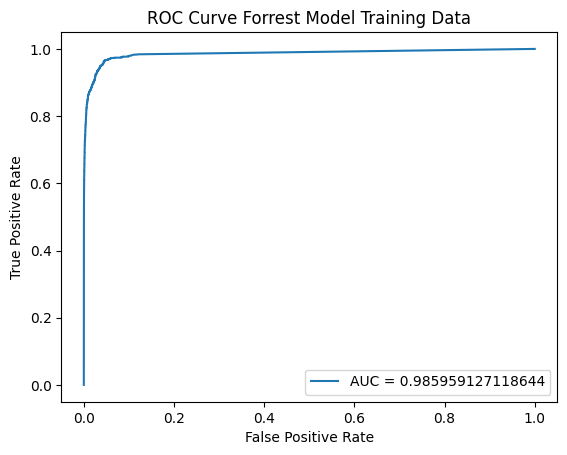

In [15]:
titles = 'Forrest Model Training Data'
getConfusionMatrix(titles, train_y, forrest_train_pred)
getAccuracyScore(titles, train_y, forrest_train_pred)
getROC(titles, train_y, forrest_train_pred_probailities)

The Confusion Matrix for Forrest Model Testing Data:
[[15614    11]
 [  173   202]]
The Accuracy Score for Forrest Model Testing Data
0.9885


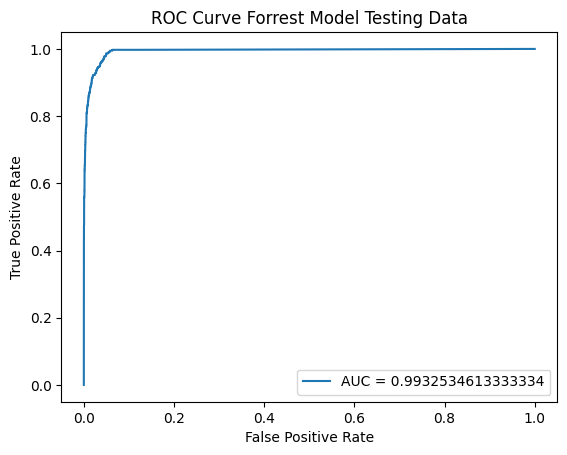

In [16]:
titles = 'Forrest Model Testing Data'
getConfusionMatrix(titles, test_y, forrest_test_pred)
getAccuracyScore(titles, test_y, forrest_test_pred)
getROC(titles, test_y, forrest_test_pred_probailities)

In [17]:
score_OOB = 1 - forrest_model.oob_score_

pd.DataFrame({'Out Of Bag Train Data': score_OOB, 'Test Data': 1-accuracy_score(test_y, forrest_test_pred)}, index=['Errors'])

,Out Of Bag Train Data,Test Data
Errors,0.009117,0.0115


### (d) Research class imbalance in random forest

In [18]:
balanced_forrest_model = RandomForestClassifier(max_depth=5, random_state=30, oob_score=True, class_weight='balanced')
balanced_forrest_model.fit(train_x, train_y)

balanced_forrest_train_pred = balanced_forrest_model.predict(train_x)
balanced_forrest_train_pred_probabilities = balanced_forrest_model.predict_proba(train_x)

balanced_forrest_test_pred = balanced_forrest_model.predict(test_x)
balanced_forrest_test_pred_probabilities = balanced_forrest_model.predict_proba(test_x)

The Confusion Matrix for Balanced Forrest Model Training Data:
[[56609  2391]
 [   30   970]]
The Accuracy Score for Balanced Forrest Model Training Data
0.95965


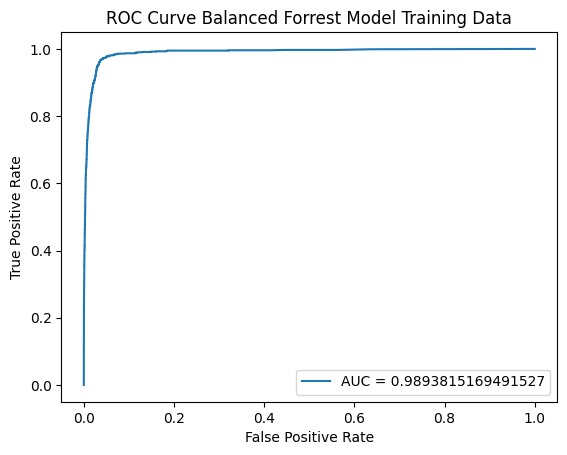

In [19]:
titles = 'Balanced Forrest Model Training Data'
getConfusionMatrix(titles, train_y, balanced_forrest_train_pred)
getAccuracyScore(titles, train_y, balanced_forrest_train_pred)
getROC(titles, train_y, balanced_forrest_train_pred_probabilities)

The Confusion Matrix for Balanced Forrest Model Testing Data:
[[15015   610]
 [   15   360]]
The Accuracy Score for Balanced Forrest Model Testing Data
0.9609375


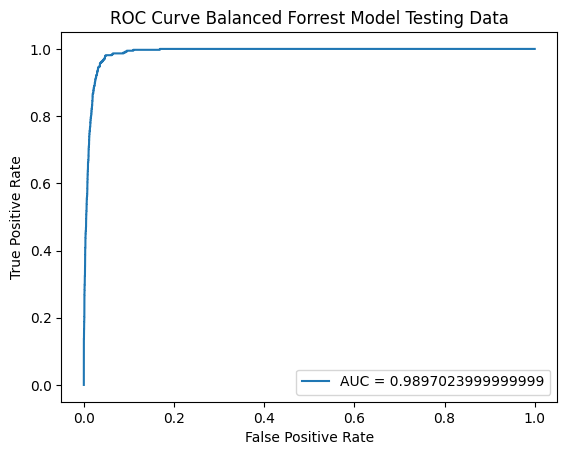

In [20]:
titles = 'Balanced Forrest Model Testing Data'
getConfusionMatrix(titles, test_y, balanced_forrest_test_pred)
getAccuracyScore(titles, test_y, balanced_forrest_test_pred)
getROC(titles, test_y, balanced_forrest_test_pred_probabilities)

In [21]:
balanced_score_OOB = 1 - balanced_forrest_model.oob_score_
pd.DataFrame({'Balanced Out Of Bag Train Data': balanced_score_OOB, 'Balanced Test Data': 1-accuracy_score(test_y, balanced_forrest_test_pred)}, index=['Errors'])

,Balanced Out Of Bag Train Data,Balanced Test Data
Errors,0.041267,0.039062


### Compare the results

The test accuracy for imbalanced model is better than that of balanced model becasue  there is are larger number of datapoints which have a 'neg' class. This imbalance causes the model to predict 'neg' for more points giving us an overall larger accuracy score but causes larger number of errors in predicting the 'pos' class. However, in the balanced class this issue is fixed, at the cost of some accuracy, and we are better able to predict the 'pos' class.

### (e) XGBoost and Model Trees

In [22]:
train_y.loc[train_y['class'] == 'neg', 'class'] = 0
train_y.loc[train_y['class'] == 'pos', 'class'] = 1
train_y = train_y['class'].astype('category')

In [23]:
test_y.loc[test_y['class'] == 'neg', 'class'] = 0
test_y.loc[test_y['class'] == 'pos', 'class'] = 1
test_y = test_y['class'].astype('category')

In [24]:
cv = KFold(n_splits=5, shuffle=True, random_state=30)
xgb_model = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=200, objective='binary:logistic')
param_grid = {'reg_alpha': [10**i for i in range(-6, 6)]}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=cv)
grid_search.fit(train_x, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=30, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     int...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'reg_alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1,
                                       1, 10, 100, 1000, 10000, 100000]},
             scoring='accuracy')

In [25]:
xgb_best_model = grid_search.best_estimator_

xgb_train_y_pred = xgb_best_model.predict(train_x)
xgb_train_y_pred_probabilities = xgb_best_model.predict_proba(train_x)

xgb_test_y_pred = xgb_best_model.predict(test_x)
xgb_test_y_pred_probabilities = xgb_best_model.predict_proba(test_x)

print('Best value of hyperparameter alpha is ', grid_search.best_params_)
print('XGB Train Score: ', accuracy_score(train_y, xgb_train_y_pred))
print('XGB Test Accuracy score: ', accuracy_score(test_y, xgb_test_y_pred))

Best value of hyperparameter alpha is  {'reg_alpha': 1}
XGB Train Score:  0.9973666666666666
XGB Test Accuracy score:  0.993


In [26]:
def getXGBROC(info, y, y_probabilities):
    fpr, tpr, thres = roc_curve(y, y_probabilities[:, 1])
    plt.plot(fpr, tpr, label="AUC = {}".format(auc(fpr, tpr)))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve {}".format(info))
    plt.legend()
    plt.show()

The Confusion Matrix for XGB Training Data:
[[58984    16]
 [  142   858]]
The Accuracy Score for XGB Training Data
0.9973666666666666


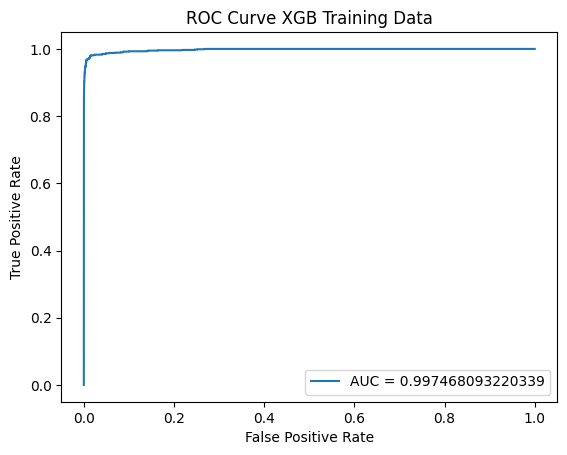

In [27]:
titles = 'XGB Training Data'
getConfusionMatrix(titles, train_y, xgb_train_y_pred)
getAccuracyScore(titles, train_y, xgb_train_y_pred)
getXGBROC(titles, train_y, xgb_train_y_pred_probabilities)

The Confusion Matrix for XGB Testing Data:
[[15609    16]
 [   96   279]]
The Accuracy Score for XGB Testing Data
0.993


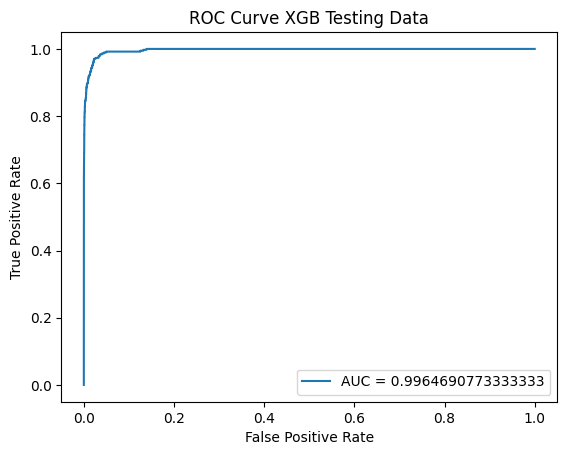

In [28]:
titles = 'XGB Testing Data'
getConfusionMatrix(titles, test_y, xgb_test_y_pred)
getAccuracyScore(titles, test_y, xgb_test_y_pred)
getXGBROC(titles, test_y, xgb_test_y_pred_probabilities)

### (f) Use SMOTE to pre-process your data

In [29]:
stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

balanced_xgb_model = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=200, objective='binary:logistic')
balancer = SMOTE()

pipe = Pipeline(steps=[("SMOTE", balancer), ("Model", balanced_xgb_model)])
balanced_param_grid = {'Model__reg_alpha': [10**i for i in range(-6, 6)]}

balanced_grid_search = GridSearchCV(pipe, param_grid=balanced_param_grid, scoring='accuracy', cv=stratified)
balanced_grid_search.fit(train_x, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('SMOTE', SMOTE()),
                                       ('Model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=200,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'Model__reg_alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                              0.1, 1, 10, 100, 1000, 10000,
                                              100000]},
             scoring='accuracy')

In [30]:
balanced_best_model = balanced_grid_search.best_estimator_

balanced_xgb_train_y_pred = balanced_best_model.predict(train_x)
balanced_xgb_train_y_pred_probabilities = balanced_best_model.predict_proba(train_x)

balanced_xgb_test_y_pred = balanced_best_model.predict(test_x)
balanced_xgb_test_y_pred_probabilities = balanced_best_model.predict_proba(test_x)

print('Best value of hyperparameter alpha is ', balanced_grid_search.best_params_)
print('Balanced XGB Train Accuracy score: ', accuracy_score(train_y, balanced_xgb_train_y_pred))
print('Balanced XGB Test Accuracy score: ', accuracy_score(test_y, balanced_xgb_test_y_pred))

Best value of hyperparameter alpha is  {'Model__reg_alpha': 1}
Balanced XGB Train Accuracy score:  0.9906166666666667
Balanced XGB Test Accuracy score:  0.98775


The Confusion Matrix for Balanced XGB Training Data:
[[58521   479]
 [   84   916]]
The Accuracy Score for Balanced XGB Training Data
0.9906166666666667


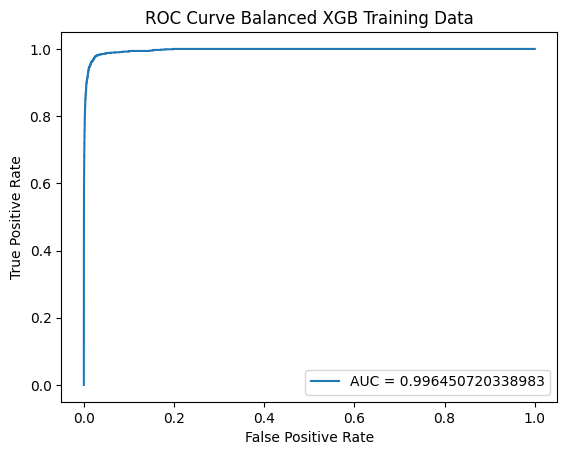

In [31]:
titles = 'Balanced XGB Training Data'
getConfusionMatrix(titles, train_y,  balanced_xgb_train_y_pred)
getAccuracyScore(titles, train_y, balanced_xgb_train_y_pred)
getXGBROC(titles, train_y, balanced_xgb_train_y_pred_probabilities)

The Confusion Matrix for Balanced XGB Testing Data:
[[15476   149]
 [   47   328]]
The Accuracy Score for Balanced XGB Testing Data
0.98775


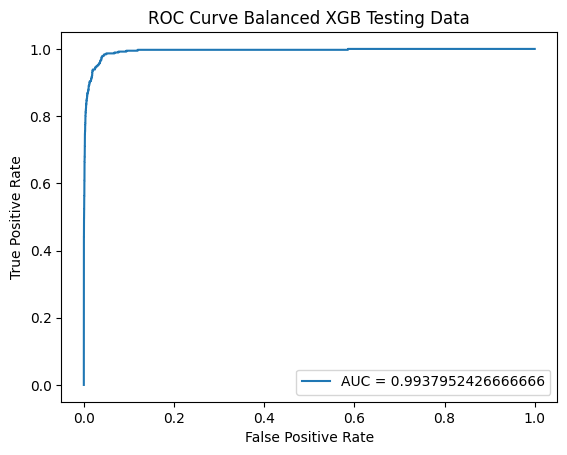

In [32]:
titles = 'Balanced XGB Testing Data'
getConfusionMatrix(titles, test_y, balanced_xgb_test_y_pred)
getAccuracyScore(titles, test_y, balanced_xgb_test_y_pred)
getXGBROC(titles, test_y, balanced_xgb_test_y_pred_probabilities)

### Comparison



Based on the confusion matrix and accuracy scores for testing data, we can see that the imbalanced XGB boost model performs better overall. However, this occurs because it predicts majority of the given data as 
'neg' leading to worse performance on data labelled as 'pos'. Therefore, in real world data the balanced version of the model would work better because based on the confusion matrix the balanced model is able to predict the 'pos' labelled data better than the imbalanced model.

## 2. ISLR 6.6.3

(a) Ans: iv

Explanation: Increase in s leads to increase in Beta values to their least square estimates which causes the training RSS to decrease steadily.

(b) Ans: ii

Explanation: Since this is the test set, as s increases the RSS will first decrease steadily, but due to overfitting, will gradually start to increase again.

(c) Ans: iii

Explanation: Increasing s is the same as increasing flexibility, and flexibility is proportional to variance therefore, as s increases the variance will increase.

(d) Ans: iv

Explanation: Since increase in s is proportional to increase in variance and using the Bias-Variance trade off, we can state that as s increases the bias will decrease. 

(e) Ans: v

Explanation: The value for irreducible error is uncorrelated to s and therefore remains constant.

## 3. ISLR 6.6.5

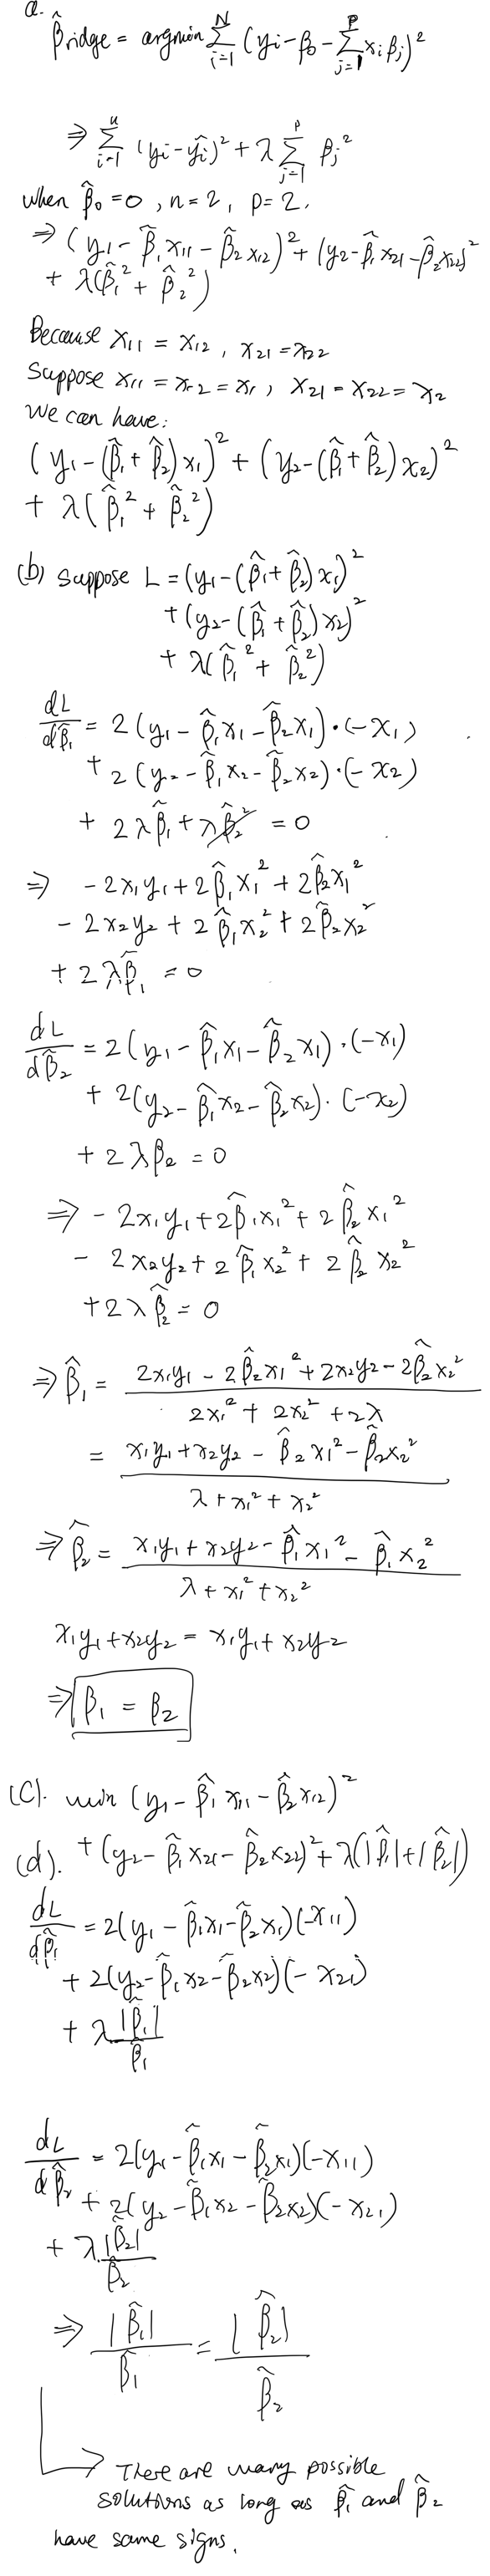

## 4. ISLR 8.4.5

In [33]:
probabilities = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])
print('If majority voting is applied, X == RED => {}'.format(sum(probabilities >= 0.5) > sum(probabilities < 0.5)))
print()
print('If average of the probabiliites is applied, the average of all the probabilities is {}.\nWhich is less than 50% therefore prediction will be GREEN'.format(np.mean(probabilities)))

If majority voting is applied, X == RED => True

If average of the probabiliites is applied, the average of all the probabilities is 0.45.
Which is less than 50% therefore prediction will be GREEN


## 5. ISLR 9.7.3

In [34]:
x1 = [3,2,4,1,2,4,4]
x2 = [4,2,4,4,1,3,1]
y = ['Red','Red','Red','Red','Blue','Blue','Blue']
colors = ["red", "red", "red", "red", "blue", "blue", "blue"]

### (A)

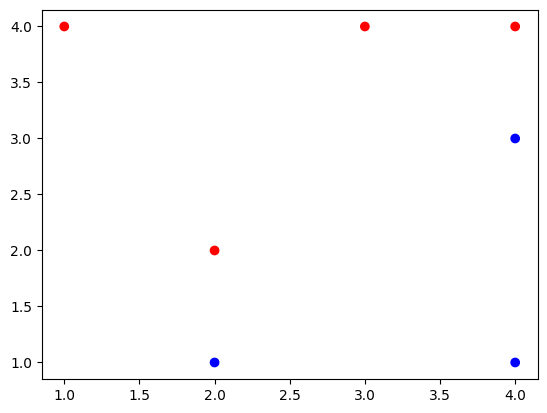

In [35]:
plt.scatter(x1, x2, c=colors)
plt.show()

#### (B)

The maximum minimum margin the datapoints is between the points (4,3), (2,1) and (4,4),(2,2). => 
The maximum minimum margin must pass the following midpoints: (2, 1.5) and (4,3.5). Which have a slope of (3.5 - 1.5)/(4-2) == 1. The intercept, with the mentioned slope is, 1.5 - 2 => -0.5

Thus equation of the hyperplane is "0.5 - X1 + X2 = 0"

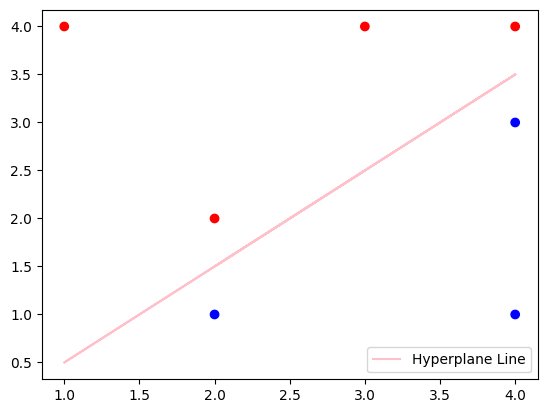

In [36]:
# X2 = X1 - 0.5
plt.plot(x1, np.array(x1)-0.5, color='pink', label='Hyperplane Line')
plt.scatter(x1,x2, c=colors)
plt.legend(loc='best')
plt.show()

### (C)

If we want to classify for red is the equation to use is "0.5 - X1 + X2 > 0"

### (D)

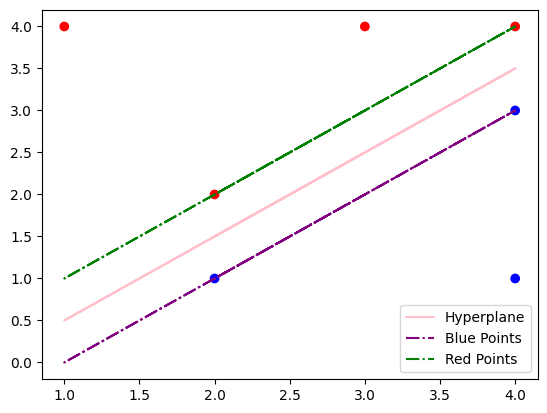

In [37]:
plt.plot(x1,np.array(x1)-0.5, color='pink', label='Hyperplane')
plt.plot(x1,np.array(x1)-1, color='purple', label='Blue Points', linestyle='dashdot')
plt.plot(x1,np.array(x1), color='green', label='Red Points', linestyle='dashdot')

plt.scatter(x1,x2, c=colors)

plt.legend(loc='best')
plt.show()

### (E)

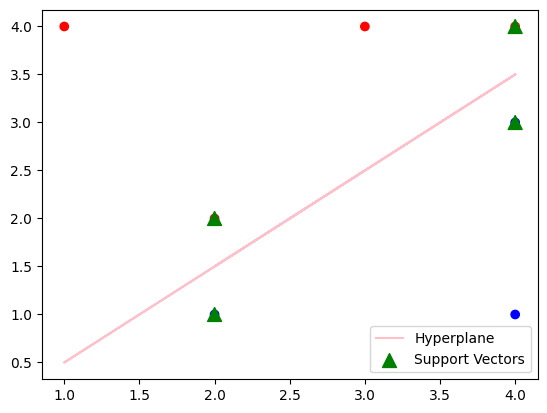

In [38]:
plt.plot(x1,np.array(x1)-0.5,color='pink', label='Hyperplane')
plt.scatter(x1,x2, c=colors)
plt.scatter([2,2,4,4],[2,1,3,4], marker="^", sizes= [100 for i in range(4)], color='green', label="Support Vectors")
plt.legend(loc='best')
plt.show()

### (F)

If we slightly moved the point #7, (4,1) there would be no impact to the Maximal Margin Hyperplane because the movement is outside the marginal area.

### (G)

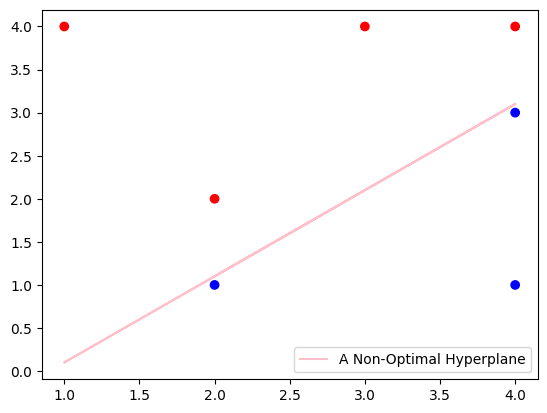

In [39]:
plt.plot(x1,np.array(x1)-0.9,color='pink', label='A Non-Optimal Hyperplane')
plt.scatter(x1,x2, c=colors)
plt.legend(loc='best')
plt.show()

EQN: -0.9 - X1 + X2 = 0

### (H)

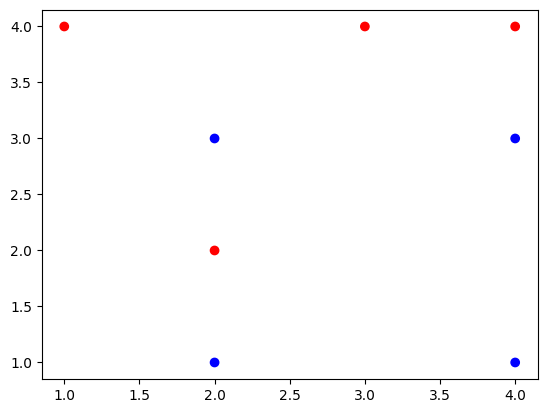

In [40]:
x1 = [3,2,4,1,2,4,4,2]
x2 = [4,2,4,4,1,3,1,3]
y = ['Red','Red','Red','Red','Blue','Blue','Blue','Blue']
c = ["red", "red", "red", "red", "blue", "blue", "blue", "blue"]
plt.scatter(x1,x2, c=c)
plt.show()

# References:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://xgboost.readthedocs.io/en/stable/python/python_api.html

https://stackoverflow.com/questions/55777491/how-to-plot-large-range-values-with-matplotlib

https://seaborn.pydata.org/generated/seaborn.objects.Plot.scale.html